Imports

In [10]:
from Models import *
from src.digit_functions import loadTestDigits, loadDigits
from src.sudoku_functions import loadSudokus
from src.sudoku_solver_functions import *
from src.feature_functions import *

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2 as cv

Models

In [11]:
pixelModel = torch.load("./models/pixel.pth")

Datasets

In [12]:
digitDataset = loadDigits("./data/digits/")
print(f"(+) Digit dataset shape: ({digitDataset[0][0].shape}, {digitDataset[0][1].shape}), ({digitDataset[1][0].shape}, {digitDataset[1][1].shape})")
preprocessedDigitDataset = loadTestDigits("./data/digits/preprocessed")
print(f"(+) Preprocessed digit dataset shape: ({preprocessedDigitDataset[0].shape}, {preprocessedDigitDataset[1].shape})")
pixelTransformedDigitDataset = loadTestDigits("./data/digits/transformed/pixel")
print(f"(+) Pixel tranformed digit dataset shape: ({pixelTransformedDigitDataset[0].shape}, {pixelTransformedDigitDataset[1].shape})")
sudokuDataset = loadSudokus("./data/sudokus")
print(f"(+) Sudoku dataset shape: ({sudokuDataset[0].shape}, {sudokuDataset[1].shape})")

(+) Reading data from .npy file...
(+) Digit loading finished
(+) Digit dataset shape: ((1496250, 40, 40), (1496250,)), ((78750, 40, 40), (78750,))
(+) Reading data from .npy file...
(+) Digit loading finished
(+) Preprocessed digit dataset shape: ((78750, 40, 40), (78750,))
(+) Reading data from .npy file...
(+) Digit loading finished
(+) Pixel tranformed digit dataset shape: ((78750, 1600), (78750,))
(+) Reading data from .npy file...
(+) Sudoku loading finished
(+) Sudoku dataset shape: ((55,), (55, 9, 9))


### Pixel Model Performance

Digits

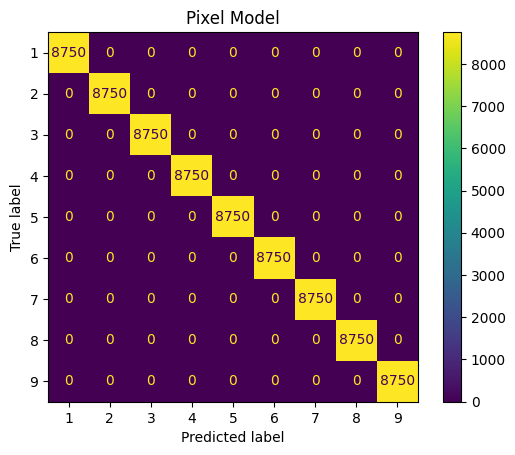

In [13]:
X = torch.tensor(pixelTransformedDigitDataset[0], dtype=torch.float32)

_Y = pixelModel(X)
_Y: np.ndarray = torch.argmax(_Y, dim=1).detach().numpy()

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pixelTransformedDigitDataset[1] - 1, _Y), display_labels = range(1, 10))
cm_display.plot()
plt.title("Pixel Model")
plt.savefig("./figures/pixelModelConfusionMatrixOnDigits.png")

Sudokus

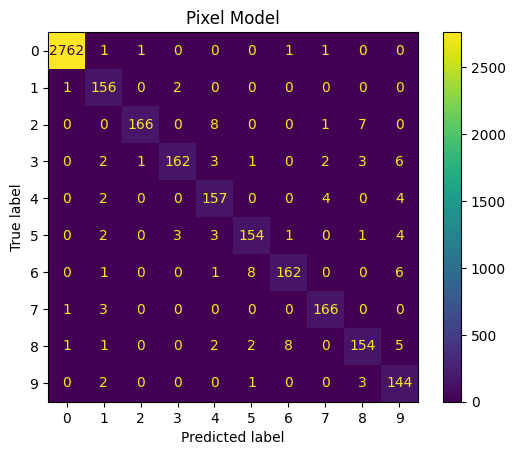

In [14]:
sudokus = (sudokuDataset[0].copy(), sudokuDataset[1].copy())
models = [pixelModel]
featureFunctions = [pixelFeatureFunction]

totalSudokusFound = 0
solvedSudokusCount = 0
notSolvedSudokus = []

trueDigits = []
predictedDigits = []

zeroPredeterminationErrors = {
    'trueZero': [],
    'predZero': []
}
wrongClassifications = {}
for i in range(1, 10):
    wrongClassifications[i] = []
correctClassifications = {}
for i in range(0, 10):
    correctClassifications[i] = []



for data, label in zip(sudokus[0], sudokus[1]):

    img = data.copy()
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sudokuImageGrayScale, sudokuContours = detectSudokuInGrayScaleImage(imgGray)

    if sudokuImageGrayScale is None or sudokuContours is None: 
        continue

    cells = retrieveCellsFromSudokuImage(sudokuImageGrayScale)

    sudoku = classifyCells(cells, models, featureFunctions)
    totalSudokusFound += 1

    wouldHaveSolved = True
    for xIndex in range(0, 9):
        for yIndex in range(0, 9):
            _y = sudoku[xIndex, yIndex]
            y = label[xIndex, yIndex]

            if _y != y: 
                wouldHaveSolved = False
                if y == 0:
                    zeroPredeterminationErrors['trueZero'].append(cells[xIndex, yIndex])
                else:
                    if _y == 0:
                        zeroPredeterminationErrors['predZero'].append(cells[xIndex, yIndex])
                    else:
                        wrongClassifications[y].append((cells[xIndex, yIndex], _y, y))
            else: 
                correctClassifications[y].append((cells[xIndex, yIndex], _y, y))
            predictedDigits.append(_y)
            trueDigits.append(y)
        
    if wouldHaveSolved:
        solvedSudokusCount += 1
    else: 
        notSolvedSudokus.append((data.copy(), label.copy()))

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trueDigits, predictedDigits), display_labels = range(0, 10))
cm_display.plot()
plt.title("Pixel Model")
plt.savefig("./figures/pixelModelConfusionMatrixOnSudokus.png")

In [24]:
twoFours = list(filter(lambda item: item[1] == 4, wrongClassifications[2]))
print(f"{len(twoFours)} true 2's have been classified as 4's ...")

sixFives = list(filter(lambda item: item[1] == 5, wrongClassifications[6]))
print(f"{len(sixFives)} true 6's have been classified as 5's ...")

trueTwos = correctClassifications[2]
trueFours = correctClassifications[4]
trueFives = correctClassifications[5]
trueSixes = correctClassifications[6]
print(f"{len(trueTwos)} true 2's have been classified as 2's ...")
print(f"{len(trueFours)} true 4's have been classified as 4's ...")
print(f"{len(trueFives)} true 5's have been classified as 5's ...")
print(f"{len(trueSixes)} true 6's have been classified as 6's ...")

pixelTransformedTwoFours = []
for cell, _, _ in twoFours:
    cell = cv.resize(cell, (40, 40))
    _, cell = preprocessCellImage(cell.copy())
    cell = ((255 - cell) / 255).astype(np.uint8)
    pixelTransformedTwoFours.append(pixelFeatureFunction(cell))
pixelTransformedSixFives = []
for cell, _, _ in sixFives:
    cell = cv.resize(cell, (40, 40))
    _, cell = preprocessCellImage(cell.copy())
    cell = ((255 - cell) / 255).astype(np.uint8)
    pixelTransformedSixFives.append(pixelFeatureFunction(cell))

pixelTransformedTrueTwos = []
for cell, _, _ in trueTwos:
    cell = cv.resize(cell, (40, 40))
    _, cell = preprocessCellImage(cell.copy())
    cell = ((255 - cell) / 255).astype(np.uint8)
    pixelTransformedTrueTwos.append(pixelFeatureFunction(cell))
pixelTransformedTrueFours = []
for cell, _, _ in trueFours:
    cell = cv.resize(cell, (40, 40))
    _, cell = preprocessCellImage(cell.copy())
    cell = ((255 - cell) / 255).astype(np.uint8)
    pixelTransformedTrueFours.append(pixelFeatureFunction(cell))
pixelTransformedTrueFives = []
for cell, _, _ in trueFives:
    cell = cv.resize(cell, (40, 40))
    _, cell = preprocessCellImage(cell.copy())
    cell = ((255 - cell) / 255).astype(np.uint8)
    pixelTransformedTrueFives.append(pixelFeatureFunction(cell))
pixelTransformedTrueSixes = []
for cell, _, _ in trueSixes:
    cell = cv.resize(cell, (40, 40))
    _, cell = preprocessCellImage(cell.copy())
    cell = ((255 - cell) / 255).astype(np.uint8)
    pixelTransformedTrueSixes.append(pixelFeatureFunction(cell))

8 true 2's have been classified as 4's ...
8 true 6's have been classified as 5's ...
166 true 2's have been classified as 2's ...
157 true 4's have been classified as 4's ...
154 true 5's have been classified as 5's ...
162 true 6's have been classified as 6's ...


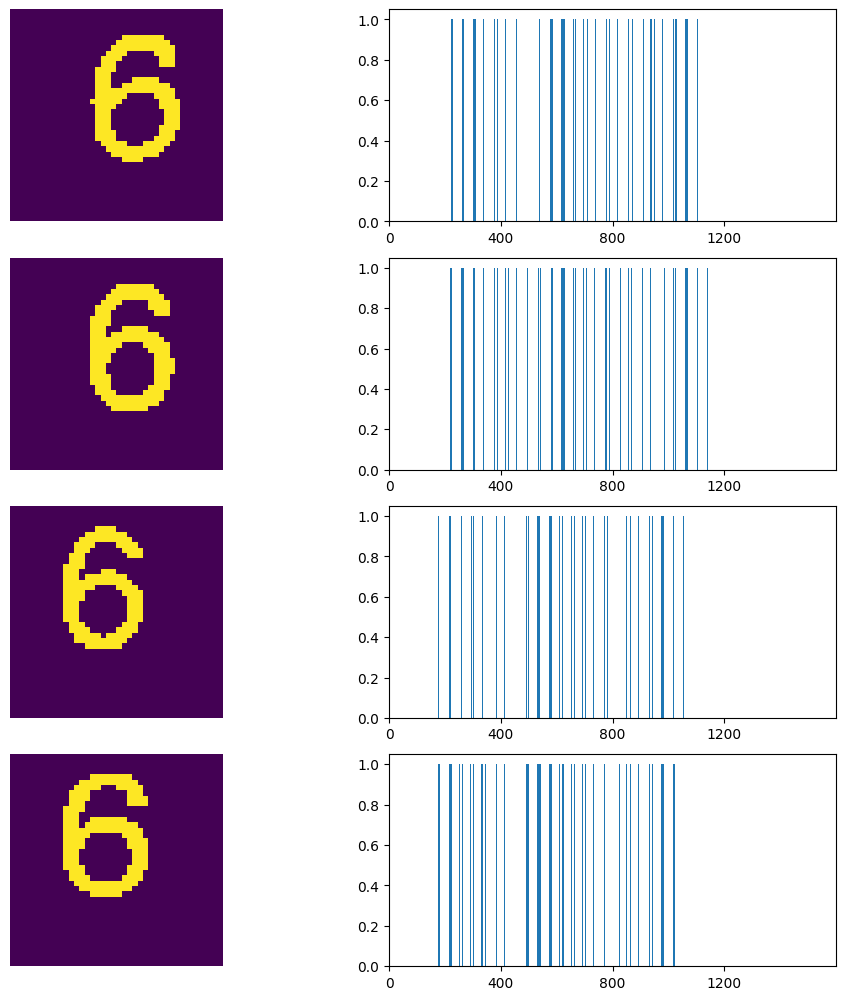

In [29]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout(pad=0.5)
x = np.arange(0, 1600, 1)
for ((img, _, _), pixelTransformed), axis in zip(zip(sixFives, pixelTransformedSixFives), axs):
    axis[0].axis('off')
    axis[0].imshow(preprocessCellImage(cv.resize(img, (40, 40)))[1])
    axis[1].set_xlim([0, 1600])
    axis[1].set_xticks(np.arange(0, 1600, 400))
    axis[1].bar(x, 1 - pixelTransformed)

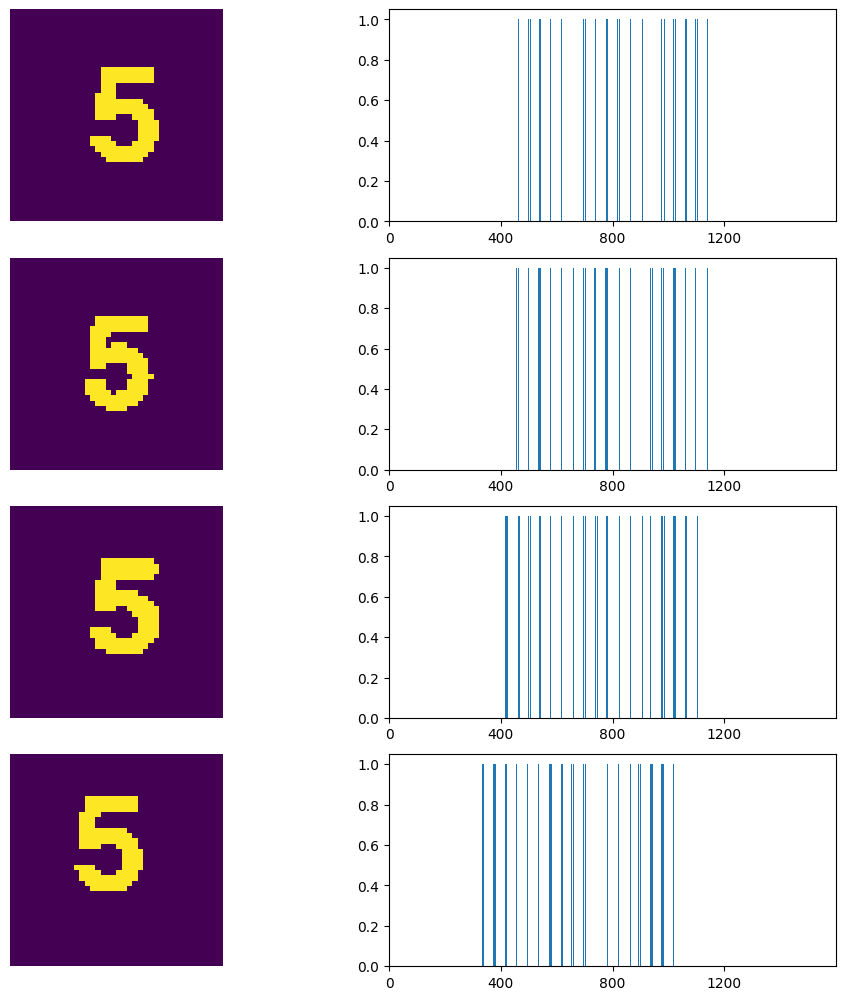

In [30]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout(pad=0.5)
x = np.arange(0, 1600, 1)
for ((img, _, _), pixelTransformed), axis in zip(zip(trueFives, pixelTransformedTrueFives), axs):
    axis[0].axis('off')
    axis[0].imshow(preprocessCellImage(cv.resize(img, (40, 40)))[1])
    axis[1].set_xlim([0, 1600])
    axis[1].set_xticks(np.arange(0, 1600, 400))
    axis[1].bar(x, 1 - pixelTransformed)

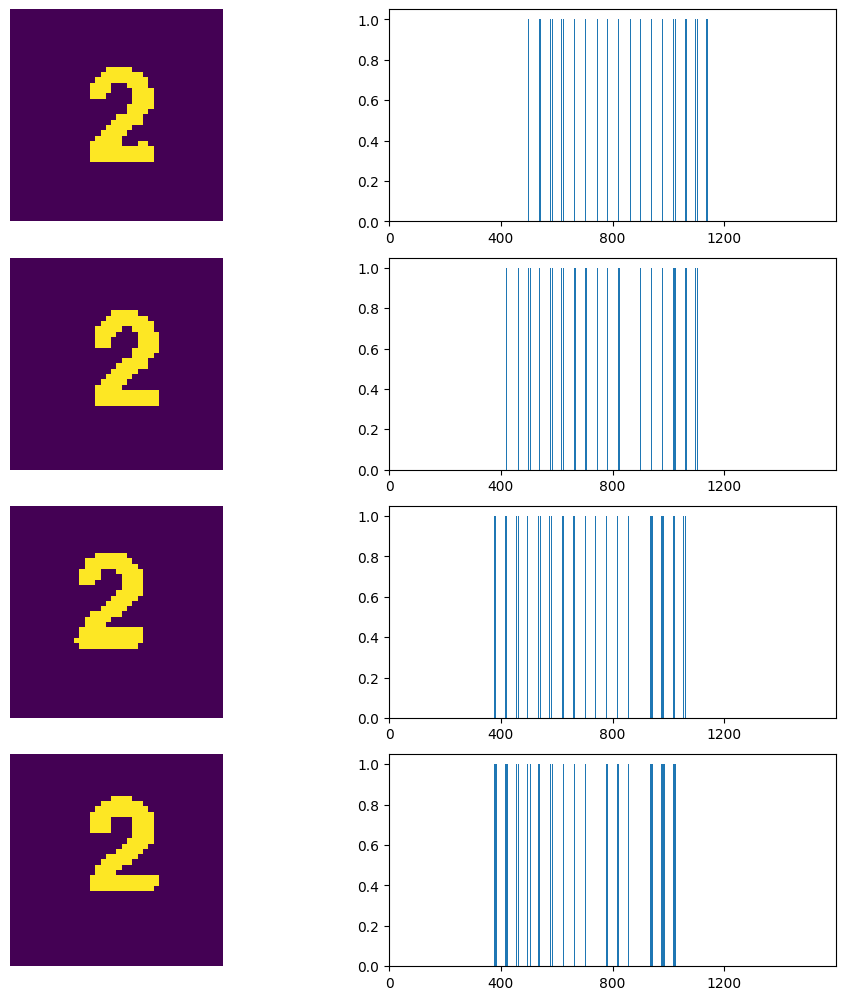

In [31]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout(pad=0.5)
x = np.arange(0, 1600, 1)
for ((img, _, _), pixelTransformed), axis in zip(zip(trueTwos, pixelTransformedTrueTwos), axs):
    axis[0].axis('off')
    axis[0].imshow(preprocessCellImage(cv.resize(img, (40, 40)))[1])
    axis[1].set_xlim([0, 1600])
    axis[1].set_xticks(np.arange(0, 1600, 400))
    axis[1].bar(x, 1 - pixelTransformed)